<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Import data & convert to df
data = pd.read_excel('Data/Online_Retail.xlsx')
df = pd.DataFrame(data)

# Preview
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We can see here there are multiple items and quantities purchased on each invoice. I will create another column that shows total spent on each item, so Quantity * UnitPrice. That way we can group by invoice number, customer, etc. and see the total they spent per invoice and item.

We're also going to be adding Recency, Frequency and Monetary columns so we can conduct an RMF analysis and segment customers that way as well. 

Let's take a look at some of the basics before we hop into it. 

In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**InvoiceNo** is currently an object. I'm going to change that to an integer so we'll be able to group by invoice number. 

**StockCode** can stay an object, I'm guessing it's a string. 

It's great that **InvoiceDate** is already in datetime format, because we can peak at some time series in the EDA to see if we can collect any further insights. 

In [20]:
# Check for missing values

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

It looks like we have a good amount of Null values for **CustomerID** and **Description**. Let's see how much of the total this accounts for.

In [31]:
# Description
print('Description Percent Null Values:')
print(f"{((df.Description.isnull().sum())/len(df.Description)*100).round(4)} % \n")

# CustomerID
print('Description Percent Null Values:')
print(f"{((df.CustomerID.isnull().sum())/len(df.CustomerID)*100).round(4)} % \n")

Description Percent Null Values:
0.2683 % 

Description Percent Null Values:
24.9267 % 



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


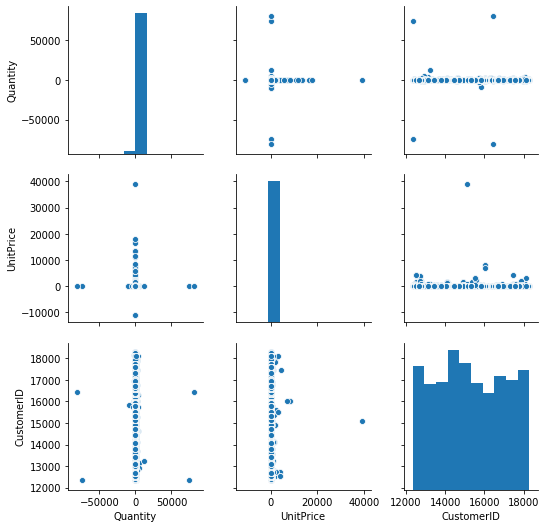

In [9]:
# Pairplot
sns.pairplot(df);

We can see there are negative values for Quantity. These most likely represent returns. 

It seems too we have some major outliers that make the rest of the data look pretty squished together, so we can take a closer look at those and clean them up if necessary. 

In [11]:
# Summary statistics

df.describe().round(4)

,Quantity,UnitPrice,CustomerID
count,541909.0000,541909.0000,406829.0000
mean,9.5522,4.6111,15287.6906
std,218.0812,96.7599,1713.6003
min,-80995.0000,-11062.0600,12346.0000
25%,1.0000,1.2500,13953.0000
50%,3.0000,2.0800,15152.0000
75%,10.0000,4.1300,16791.0000
max,80995.0000,38970.0000,18287.0000


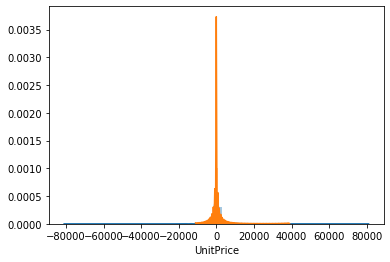

In [18]:
sns.distplot(df.Quantity)
sns.distplot(df.UnitPrice)